<a href="https://colab.research.google.com/github/hiyer7/Data-Science-Projects/blob/main/LoanTap_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

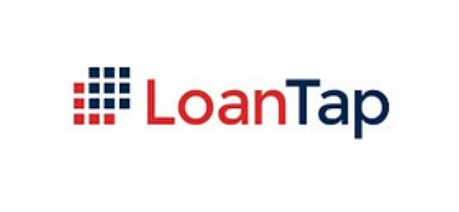

#Objective

*   List item
*   List item



#Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Data Read

In [81]:
url = "https://drive.google.com/file/d/1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d/view?usp=drive_link"
file_id = url.split('/')[-2]
download_url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(download_url)

In [82]:
df.head(1)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"


#2. EDA

In [83]:
df.shape

(396030, 27)

In [84]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

##Empty Columns

In [86]:
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0]  # Optional: only show columns with missing values
missing_percent = missing_percent.round(2).sort_values(ascending=False)

print(missing_percent)


mort_acc                9.54
emp_title               5.79
emp_length              4.62
title                   0.44
pub_rec_bankruptcies    0.14
revol_util              0.07
dtype: float64


In [87]:
df['emp_length'].isna().sum()

np.int64(18301)

##Unique

In [88]:
for col in df.columns:
  print(f"{col}: {df[col].nunique()}")


loan_amnt: 1397
term: 2
int_rate: 566
installment: 55706
grade: 7
sub_grade: 35
emp_title: 173105
emp_length: 11
home_ownership: 6
annual_inc: 27197
verification_status: 3
issue_d: 115
loan_status: 2
purpose: 14
title: 48816
dti: 4262
earliest_cr_line: 684
open_acc: 61
pub_rec: 20
revol_bal: 55622
revol_util: 1226
total_acc: 118
initial_list_status: 2
application_type: 3
mort_acc: 33
pub_rec_bankruptcies: 9
address: 393700


##Column wise interpretation

###sub-grade

In [89]:
df['sub_grade'].value_counts()

,count
sub_grade,
B3,26655
B4,25601
C1,23662
C2,22580
B2,22495
B5,22085
C3,21221
C4,20280
B1,19182


Since this has high cardinality and overlaps with the column grade, we will be dropping this

In [90]:
df.drop(columns='sub_grade', inplace= True)

###term

There are only two values in this.

We will convert these strings to numeric by retining only the numeric values

In [91]:
df['term'] = df['term'].str.extract('(\d+)').astype(int)

In [92]:
df['term'].astype

<bound method NDFrame.astype of 0         36
1         36
2         36
3         36
4         60
          ..
396025    60
396026    36
396027    36
396028    60
396029    36
Name: term, Length: 396030, dtype: int64>

In [93]:
df['term'].value_counts()

,count
term,
36,302005
60,94025


In [94]:
#High cardinality, no nulls

###Title and Purpose

In [95]:
df[['title', 'purpose']].head()

,title,purpose
0,Vacation,vacation
1,Debt consolidation,debt_consolidation
2,Credit card refinancing,credit_card
3,Credit card refinancing,credit_card
4,Credit Card Refinance,credit_card


 Both these columns have the same values with different columns names. We will be dropping title

In [96]:
df.drop(columns='title', inplace=True)

In [97]:
for col in df.columns:
  #print(f"{col}: {df[col].nunique()}")
  if df[col].nunique() == 2:
    print(f'{col}: Binary')

term: Binary
loan_status: Binary
initial_list_status: Binary


In [98]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

| Column                     | Issues Detected              | Comments & Suggested Treatment                                                                         |
| -------------------------- | ---------------------------- | ------------------------------------------------------------------------------------------------------ |
| **loan\_amnt**             | ✔ High cardinality, no nulls | Check for negative/zero values or outliers. Distribution analysis recommended.                         |
| **term**                   | ✔ Only 2 unique values       | Convert to numeric (36, 60). Check for leading/trailing whitespaces.                                   |
| **int\_rate**              | ✔ 566 unique values          | No nulls. Check for outliers, and scale if needed.                                                     |
| **installment**            | ✔ 55K+ unique values         | Correlated with `loan_amnt`. Investigate multicollinearity. Scale if used in model.                    |
| **grade**                  | ✔ 7 values (A–G)             | Ordinal – map A→1, B→2, etc.                                                                           |
| **sub\_grade**             | ✔ 35 values (A1–G5)          | Can be derived from grade; can encode as ordinal or one-hot.                                           |
| **emp\_title**             | ❗ 22,927 nulls, 173K unique  | Text column, too high cardinality. Consider dropping or grouping by frequency (e.g., top 10 titles).   |
| **emp\_length**            | ❗ 18,301 nulls, 11 values    | Clean values ("10+ years", "<1 year", "n/a"), convert to numeric. Impute missing with mode or unknown. |
| **home\_ownership**        | ✔ 6 values                   | One-hot or ordinal encode. Validate for odd categories (e.g., "ANY").                                  |
| **annual\_inc**            | ✔ 0 nulls, 27K unique        | Check for outliers (e.g., income > 10 million), log transform if skewed.                               |
| **verification\_status**   | ✔ 3 categories               | One-hot encode.                                                                                        |
| **issue\_d**               | ✔ 115 unique months          | Convert to datetime, then extract year/month if needed.                                                |
| **loan\_status**           | ✔ Target column              | Only 2 values → convert to binary: Fully Paid = 1, Charged Off = 0                                     |
| **purpose**                | ✔ 14 categories              | One-hot encode. Group rare ones into "Other" if needed.                                                |
| **title**                  | ❗ 1,756 nulls, 48K unique    | Text data; likely similar to `purpose`. Drop if redundant or use only top titles.                      |
| **dti**                    | ✔ 0 nulls                    | Check for high values >50 (indicates high debt). Treat outliers.                                       |
| **earliest\_cr\_line**     | ✔ 684 values                 | Convert to datetime. Extract year for credit history length.                                           |
| **open\_acc**              | ✔ No nulls, 61 unique        | Check if >50; may be unrealistic.                                                                      |
| **pub\_rec**               | ✔ Mostly 0s                  | Flag as binary: pub\_rec\_flag = 1 if > 0 else 0                                                       |
| **revol\_bal**             | ✔ High variance              | No nulls, scale or log-transform                                                                       |
| **revol\_util**            | ❗ 276 nulls                  | Impute using median or based on `revol_bal` group. Cap values at 100%                                  |
| **total\_acc**             | ✔ No issues                  | Standardize or scale if required                                                                       |
| **initial\_list\_status**  | ✔ 2 values                   | Encode as binary                                                                                       |
| **application\_type**      | ✔ 3 values                   | Mostly "Individual", check for imbalance                                                               |
| **mort\_acc**              | ❗ 37,795 nulls               | Impute with median or group median by `total_acc` or `open_acc`                                        |
| **pub\_rec\_bankruptcies** | ❗ 535 nulls                  | Create flag: bankruptcy\_flag. Impute missing as 0 or mode                                             |
| **address**                | ✔ 393,700 unique             | Very high cardinality, use only derived feature like zip code if required. Else drop.                  |


###Address

In [99]:
df['address'].value_counts()

,count
address,
USS Johnson\r\nFPO AE 48052,8
USNS Johnson\r\nFPO AE 05113,8
USS Smith\r\nFPO AP 70466,8
USCGC Smith\r\nFPO AE 70466,8
USNS Johnson\r\nFPO AP 48052,7
...,...
"8141 Cox Greens Suite 186\r\nMadisonstad, VT 05113",1
"8803 Sean Highway Suite 029\r\nNorth Nicoleshire, AK 11650",1
"594 Nicole Mission Apt. 620\r\nNew Patrick, NJ 00813",1


In [100]:
df['zip_code']= df['address'].str.extract(r'(\d{5})$')
#df['zip_code'].value_counts().count()
df['zip_code'] = pd.to_numeric(df['zip_code'], errors='coerce')  # converts invalid to NaN


In [101]:
df['zip_code'] = df['zip_code'].astype(int)

In [102]:
#df['state']= df['address'].str.extract(r'([A-Z]{2})\s\d{5}$')
#df['state'].value_counts().count()

Now that we have extracted useful info from the address colun, we will be dropping it

In [103]:
df.drop(columns='address', inplace=True)

###emp_title

emp_title has about 6% null values. We will be only keeping the top ten titles and grouping all others under 'other' category

In [104]:
top_ten_titles= df['emp_title'].value_counts().nlargest(10).index

df['emp_title_grouped']= df['emp_title'].apply(lambda x: x if x in top_ten_titles else 'other')
df['emp_title_grouped'].value_counts()

,count
emp_title_grouped,
other,374749
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846
Supervisor,1830
Sales,1638
Project Manager,1505
Owner,1410


In [105]:
df.drop(columns= 'emp_title', inplace= True)

###mort_acc

mort_acc has about 10% null values

We'll be imputing mort_acc using the median mort_acc per group of total_acc.

This makes sense because users with similar total_acc (total number of credit lines) are likely to have similar mortgage profiles.

In [106]:
mort_acc_medians= df.groupby('total_acc')['mort_acc'].median()#.reset_index().sort_values(by='mort_acc')#, descending=True)

def impute_mort_acc(row):
  if pd.isnull(row['mort_acc']):
    return mort_acc_medians.get(row['total_acc'], df['mort_acc'].median())
  else:
    return row['mort_acc']

df['mort_acc']= df.apply(impute_mort_acc, axis= 1)

df['mort_acc'].isna().sum()

np.int64(0)

There no null values anymore

In [107]:
df[['mort_acc', 'total_acc']].corr()

,mort_acc,total_acc
mort_acc,1.00000,0.40569
total_acc,0.40569,1.00000


There's low correlation between these two columns. Retaining both will be essential for now

###pub_rec_bankruptcies

In [108]:
df['pub_rec_bankruptcies'].value_counts()

,count
pub_rec_bankruptcies,
0.0,350380
1.0,42790
2.0,1847
3.0,351
4.0,82
5.0,32
6.0,7
7.0,4
8.0,2


In [109]:
(df['pub_rec_bankruptcies'].isna().sum()/len(df))*100

np.float64(0.13509077595131683)

In [110]:
pub_rec_bankruptcies_mode_value= df['pub_rec_bankruptcies'].mode()[0]
#pub_rec_bankruptcies_mode_value

df['pub_rec_bankruptcies']= df['pub_rec_bankruptcies'].fillna(pub_rec_bankruptcies_mode_value)
df['pub_rec_bankruptcies'].isna().sum()

np.int64(0)

###emp_length

In [111]:
df['emp_length'].value_counts()

,count
emp_length,
10+ years,126041
2 years,35827
< 1 year,31725
3 years,31665
5 years,26495
1 year,25882
4 years,23952
6 years,20841
7 years,20819


####Converting the string values to numeric

In [112]:
def convert_emp_length(val):
    if pd.isnull(val):
        return np.nan
    elif val == '10+ years':
        return 10
    elif val == '< 1 year':
        return 0
    else:
        return int(val.strip().split()[0])  # e.g., "2 years" -> 2

df['emp_length_num'] = df['emp_length'].apply(convert_emp_length)


In [113]:
df['emp_length_num'].value_counts()

,count
emp_length_num,
10.0,126041
2.0,35827
0.0,31725
3.0,31665
5.0,26495
1.0,25882
4.0,23952
6.0,20841
7.0,20819


####Imputing the missing rows with median

In [114]:
emp_length_mode = df['emp_length_num'].median()
df['emp_length_num'] = df['emp_length_num'].fillna(emp_length_mode)


In [115]:
df['emp_length_num'].isna().sum()

np.int64(0)

In [116]:
df.drop(columns='emp_length', inplace=True)

###revol_util

Revolving utilization rate: how much credit a person is using relative to their total revolving credit.

Important financial signal — high values can indicate credit stress, so it’s useful for modeling default risk.

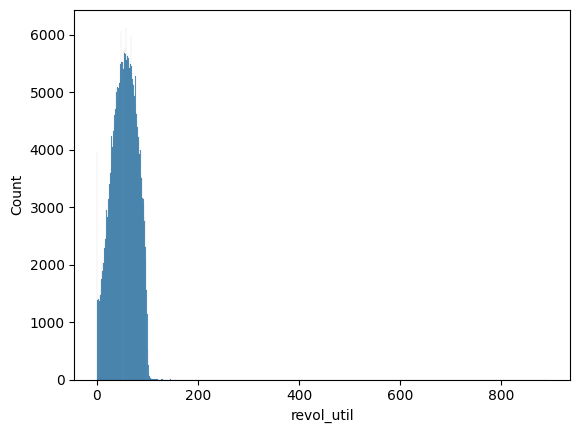

In [117]:
sns.histplot(x=df['revol_util'])
plt.show()

The bulk of the data is clustered between 0 and ~150, with a peak around 30–40.

There's a long tail and a few significant outliers (some values >800).

Overall, it shows a right-skewed distribution — not exactly normal, but fairly consistent with typical utilization rate distributions in credit datasets.

In [118]:
revol_util_median = df['revol_util'].median()
df['revol_util']= df['revol_util'].fillna(revol_util_median)


In [119]:
df['revol_util'].isna().sum()

np.int64(0)

Median is robust to outliers (e.g., if some people have 100% utilization).

This preserves the structure of your dataset and avoids distortion.

###We will come back to dealing with columns at  later stage when we



1.   Check for outliers
2.   Feature selection
3.   Checking for collinearity between the features



##Univariate Analysis

Continuous: loan_amnt, int_rate, installment, annual_inc, dti, revol_bal

Categorical: grade, home_ownership, verification_status, purpose, loan_status

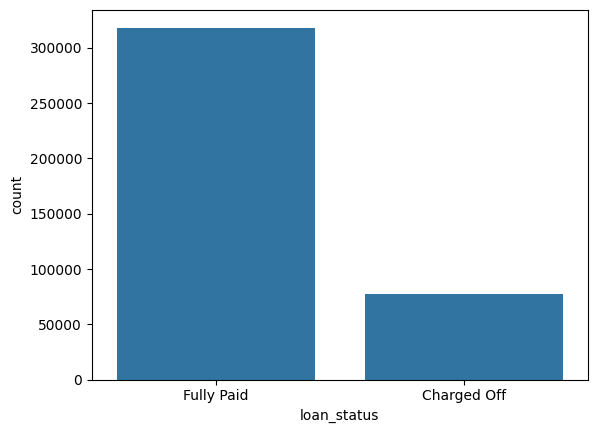

In [120]:
sns.countplot(x= 'loan_status', data= df)
plt.show()

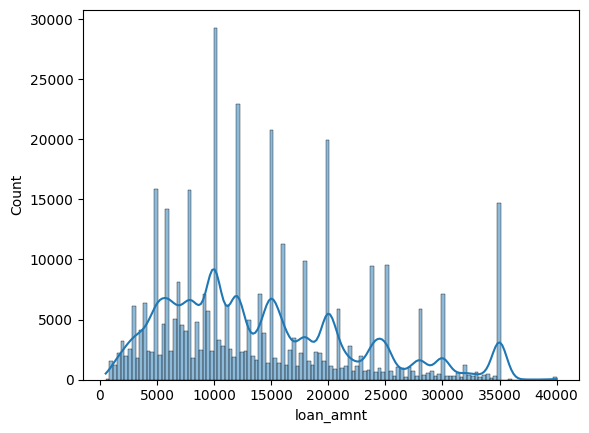

In [121]:
sns.histplot(df['loan_amnt'], kde= True)
plt.show()

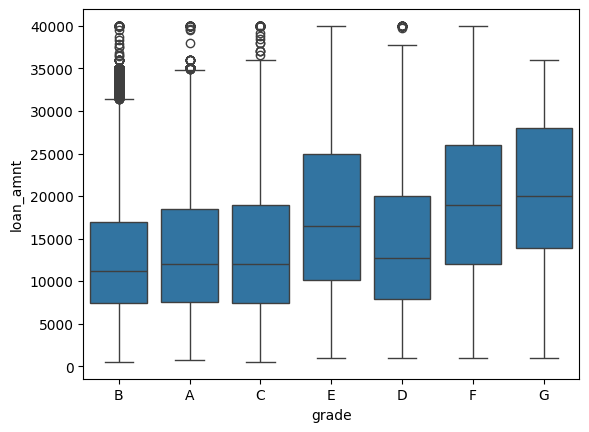

In [122]:
sns.boxplot(x= 'grade', y= 'loan_amnt', data= df)
plt.show()

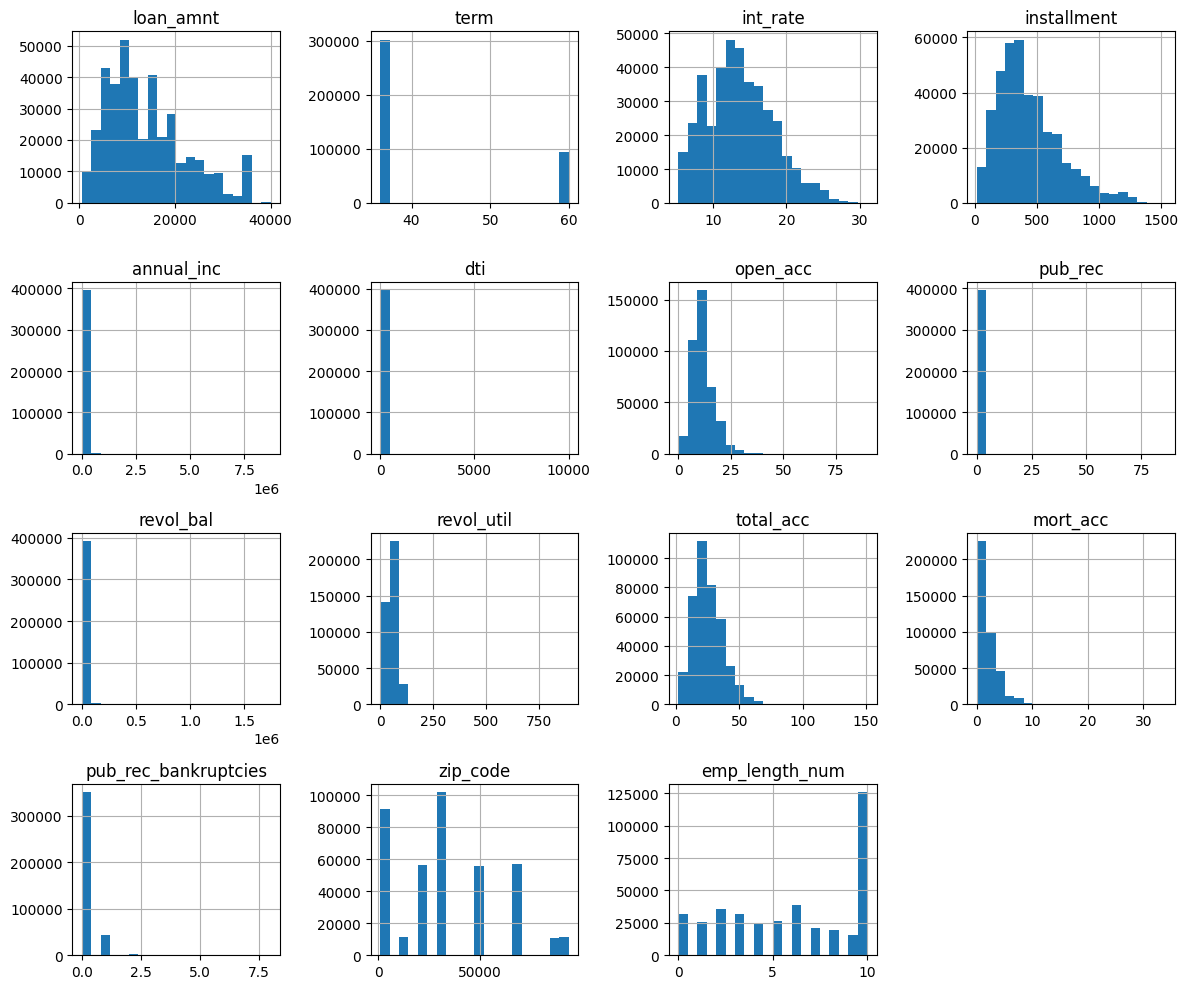

In [123]:
df.hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

##Bivariate Analysis

###Correlation Matrix

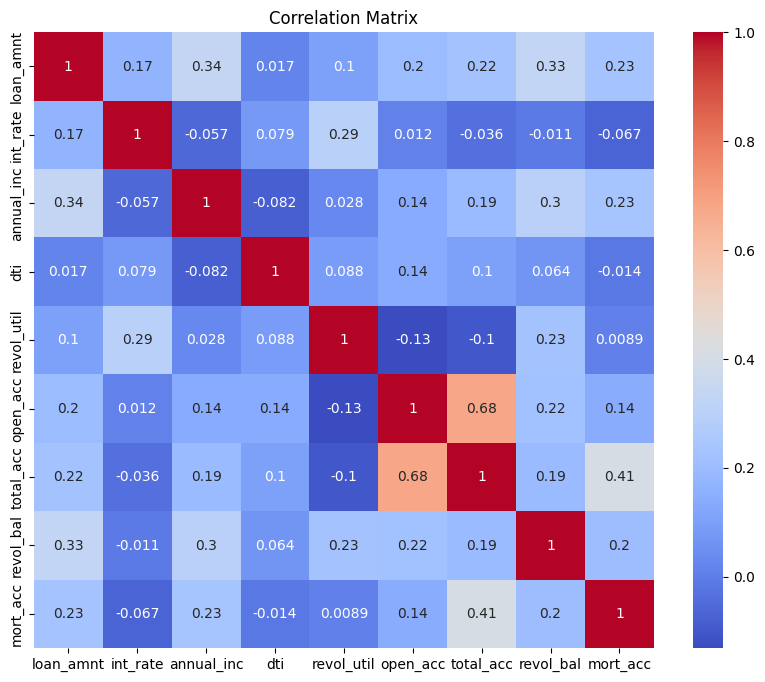

In [124]:
continuous_col= [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util',
    'open_acc', 'total_acc', 'revol_bal', 'mort_acc'
]

plt.figure(figsize=(10,8))
sns.heatmap(data=df[continuous_col].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

###Dwelving on installment vs loan_amnt

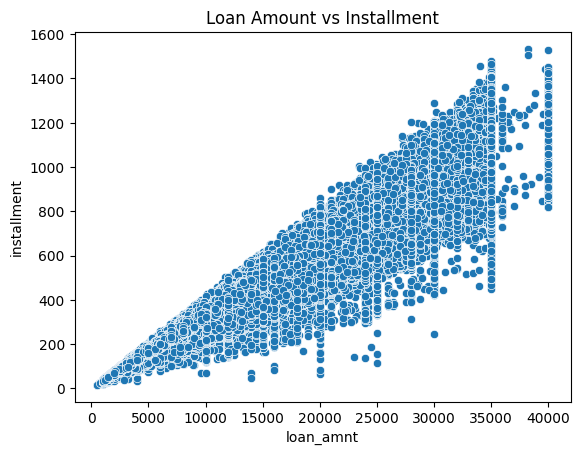

In [125]:
sns.scatterplot(x='loan_amnt', y='installment', data=df)
plt.title('Loan Amount vs Installment')
plt.show()

We see a collinear relationship between the two columns
Since installment is derived from loan_amnt, int_rate, and term, it can introduce multicollinearity in regression models.

So, we'll drop the installment column from the df, prefered keeping loan_amnt for interpretability, especially in a business context.

In [126]:
df.drop(columns= 'installment', inplace=True)

###Pairplot

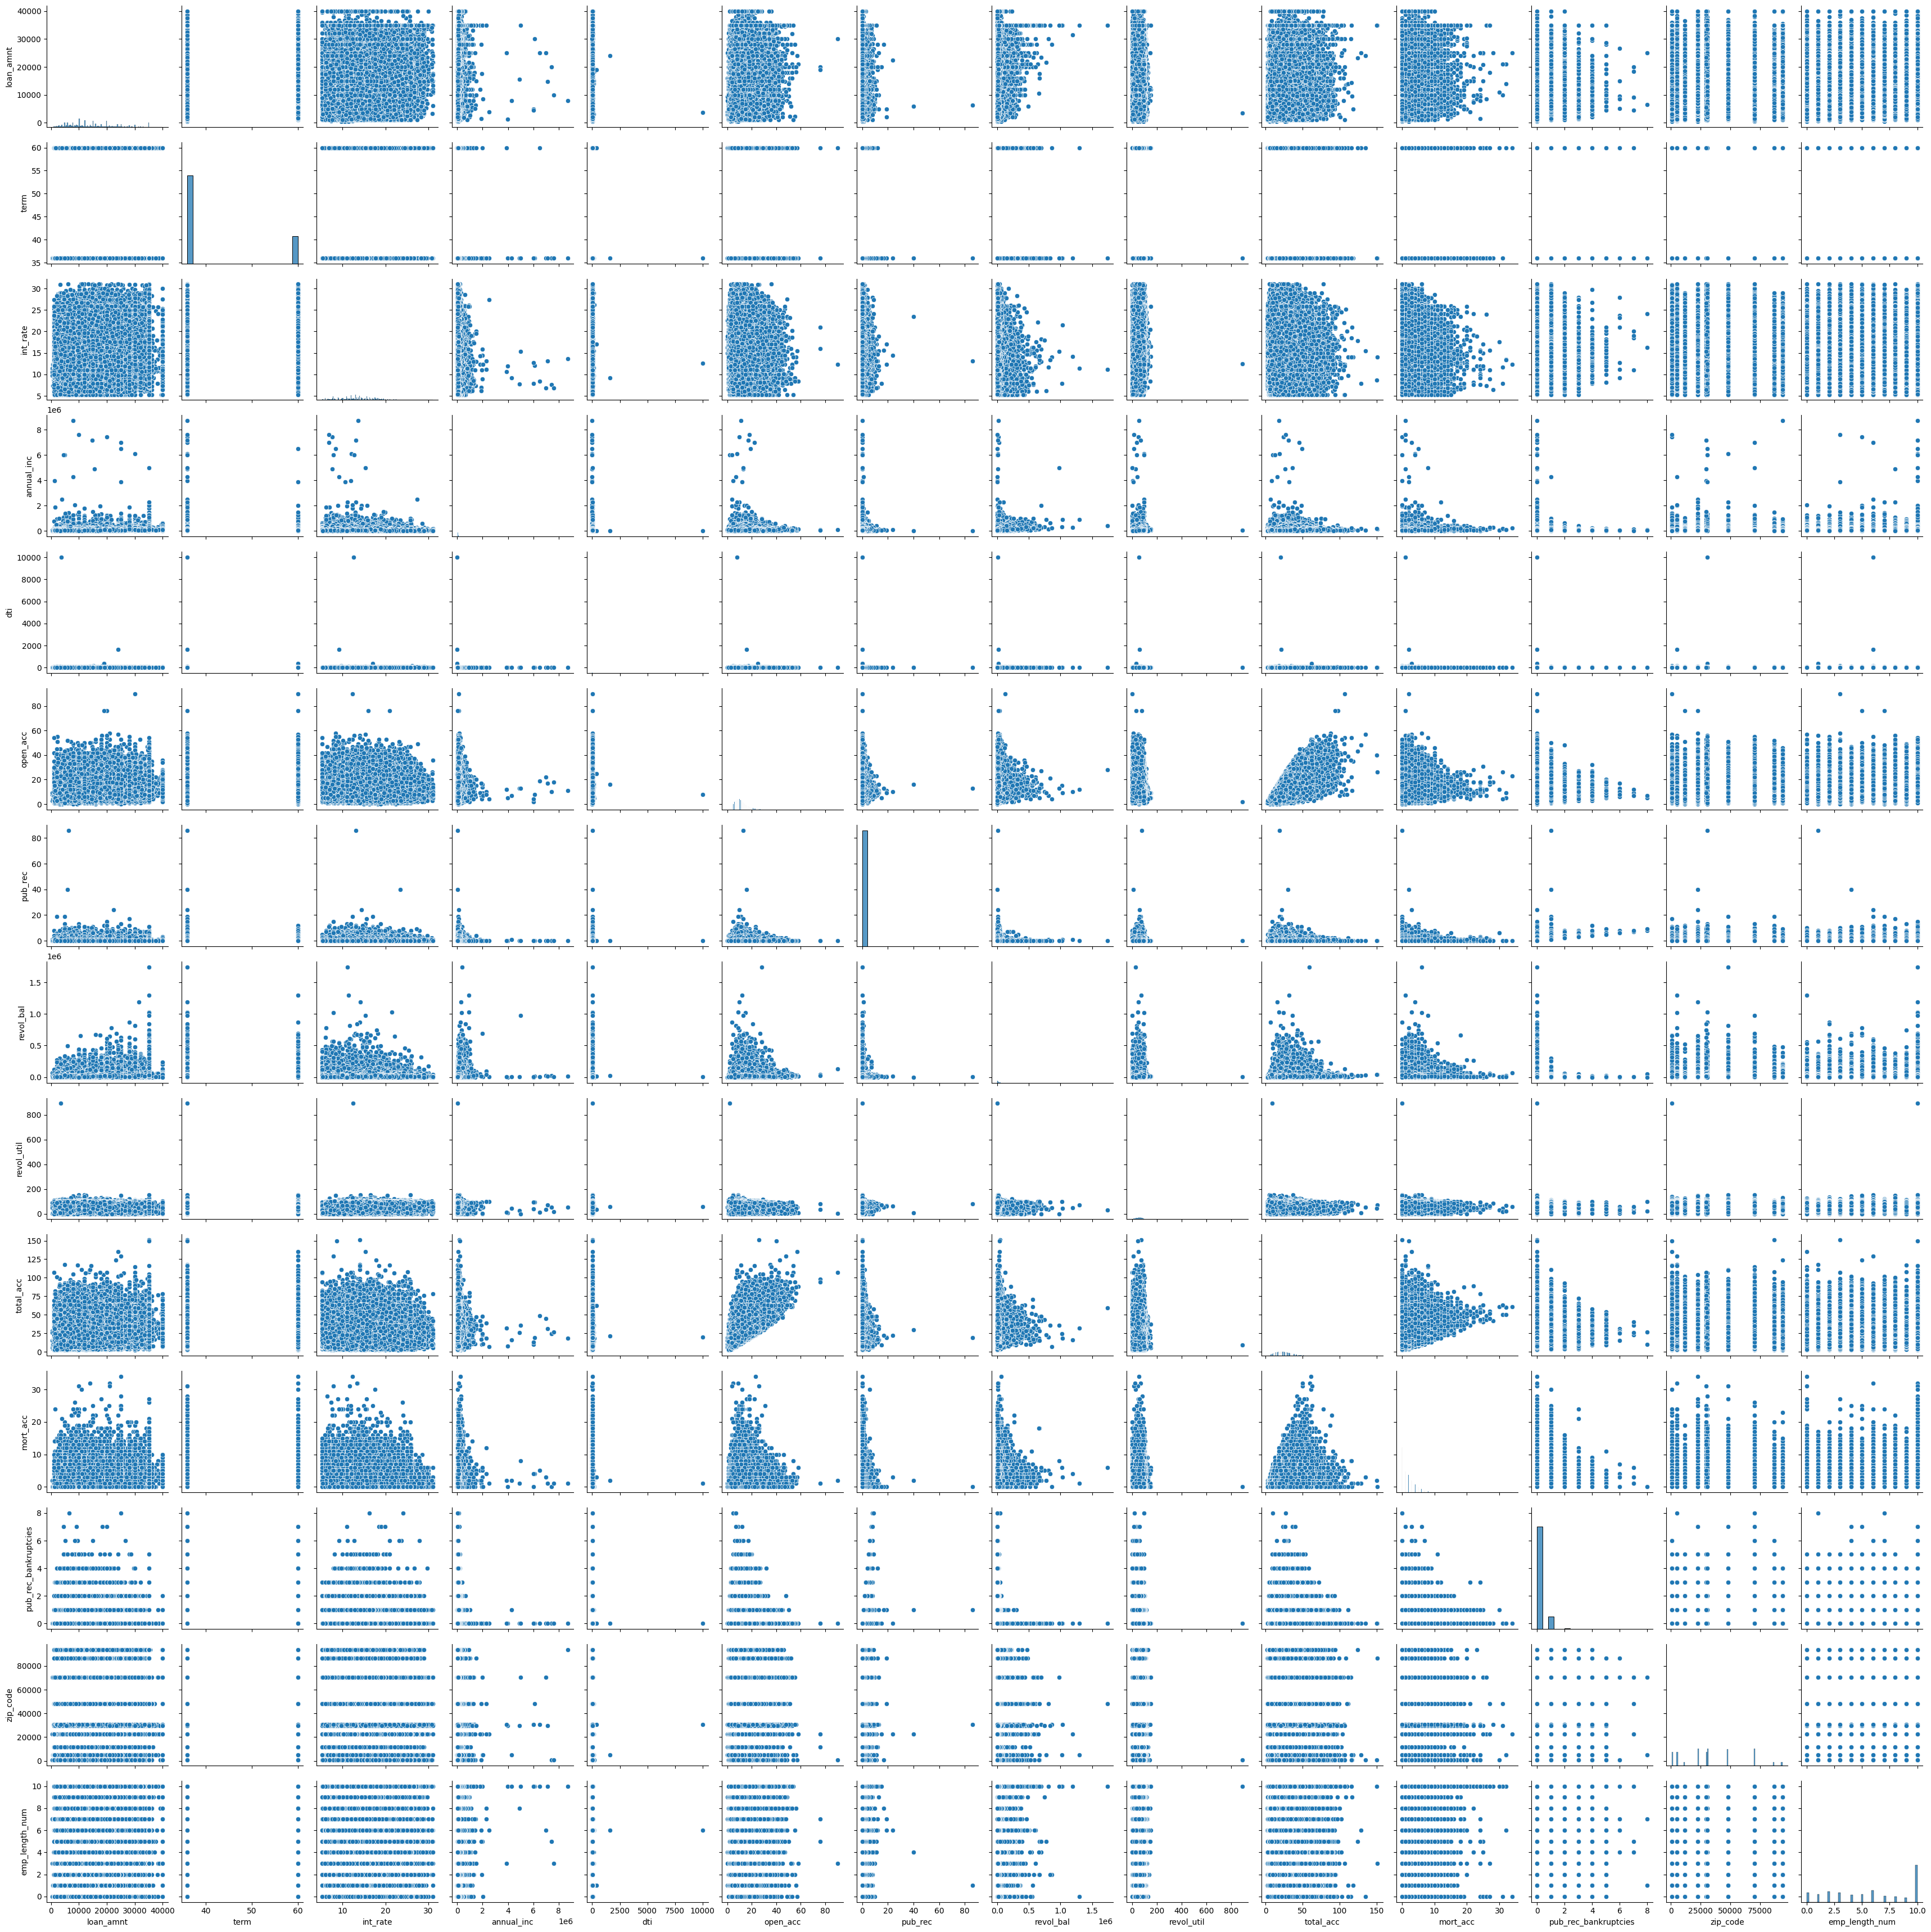

In [127]:
#sns.pairplot(df)
#plt.show()

###EDA Insights

In [128]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,318357
Charged Off,77673


Likely Influential Features for Loan Repayment (loan_status)

| Feature                                   | Why It Might Matter                                                                                                     |
| ----------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| **int\_rate** (interest rate)             | Higher interest → harder to repay. Often used for risk-based pricing.                                                   |
| **annual\_inc** (income)                  | Lower income → higher repayment stress. Strong indicator of repayment capacity.                                         |
| **dti** (debt-to-income ratio)            | Higher DTI means more debt burden. Strong predictor of financial stress.                                                |
| **emp\_length**                           | More stable employment history → less likely to default.                                                                |
| **home\_ownership**                       | Owning a home (vs renting) may indicate financial stability.                                                            |
| **pub\_rec** / **pub\_rec\_bankruptcies** | Past delinquencies or bankruptcies signal credit risk.                                                                  |
| **revol\_util**                           | High utilization of revolving credit → potential cash flow stress.                                                      |
| **grade** / **sub\_grade**                | Internal credit rating by LoanTap — probably derived from model predictions or credit bureau scores. Highly predictive. |
| **verification\_status**                  | Verified income → more trustworthy borrower.                                                                            |
| **loan\_amnt**                            | Larger loan amounts → higher monthly burden → more risk, especially if income is not high.                              |
| **term**                                  | 60-month loans may have more defaults than 36-month loans, depending on loan fatigue.                                   |
| **purpose**                               | Reason for loan — e.g., "medical" or "debt\_consolidation" may signal higher financial distress.                        |
| **application\_type**                     | Individual vs Joint — joint apps may be safer.                                                                          |
| **open\_acc / total\_acc / mort\_acc**    | Overall credit health.                                                                                                  |
| **state / zip\_code** (from `address`)    | Repayment rates may vary by region due to economic conditions.                                                          |


##Outlier Treatment

In [129]:
continuous_col = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util',
    'open_acc', 'total_acc', 'revol_bal', 'mort_acc'
]


In [130]:
df.describe()

,loan_amnt,term,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,zip_code,emp_length_num
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000
mean,14113.888089,41.698053,13.639400,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.792451,25.414744,1.741384,0.121483,33998.447686,5.941416
std,8357.441341,10.212038,4.472157,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.443685,11.886991,2.076183,0.355962,25605.865779,3.560415
min,500.000000,36.000000,5.320000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,813.000000,0.000000
25%,8000.000000,36.000000,10.490000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.900000,17.000000,0.000000,0.000000,11650.000000,3.000000
50%,12000.000000,36.000000,13.330000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000,29597.000000,6.000000
75%,20000.000000,36.000000,16.490000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000,48052.000000,10.000000
max,40000.000000,60.000000,30.990000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000,93700.000000,10.000000


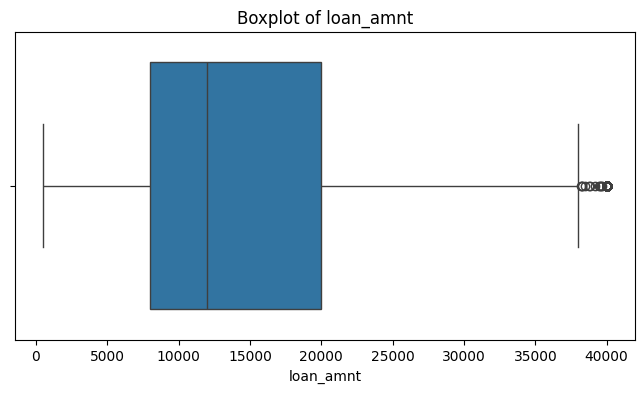

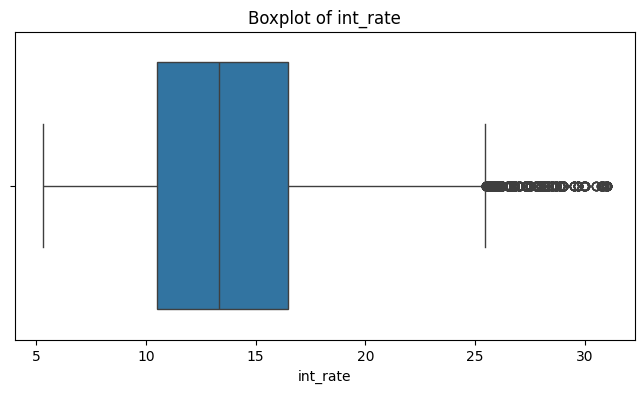

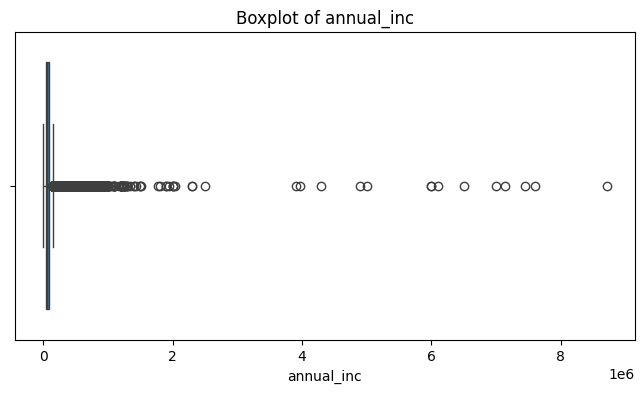

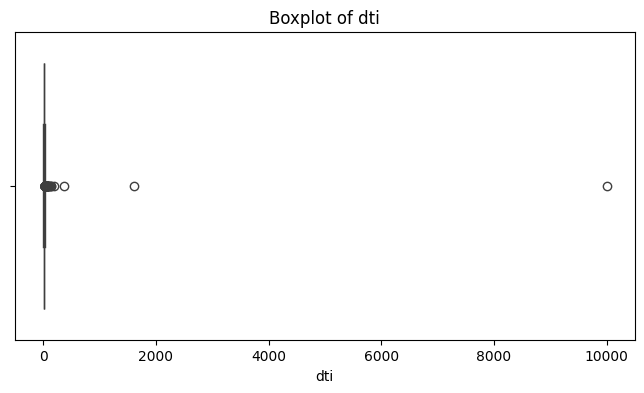

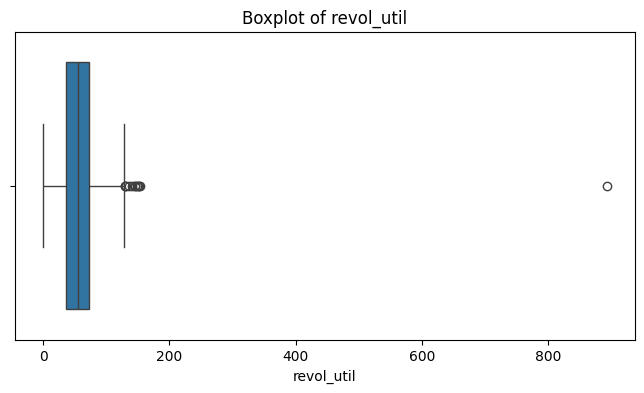

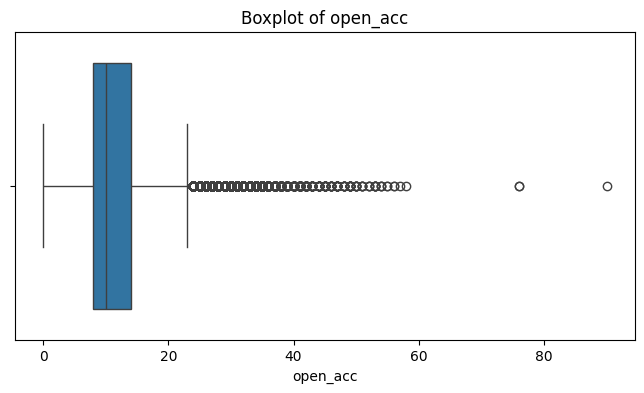

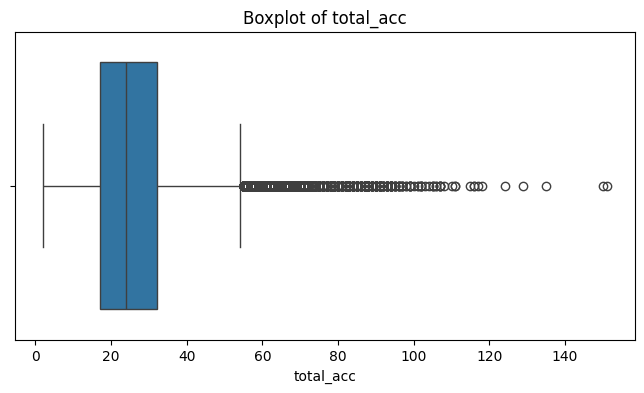

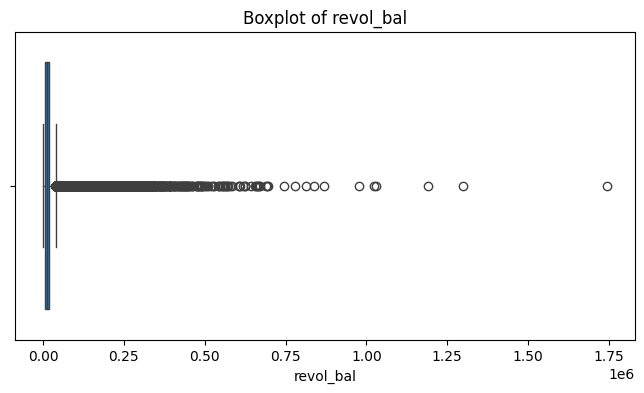

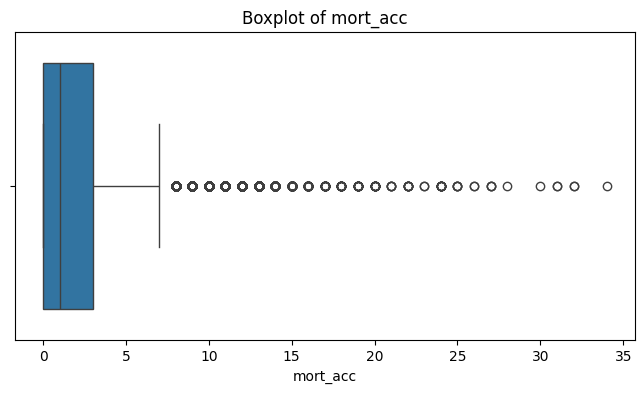

In [131]:

for col in continuous_col:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


We will cap the outliers using the IQR Capping method

In [132]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                  np.where(df[column] > upper, upper, df[column]))
    return df

# Apply to all numeric columns
for col in continuous_col:
    df = cap_outliers(df, col)

In [133]:
df[continuous_col].describe()

,loan_amnt,int_rate,annual_inc,dti,revol_util,open_acc,total_acc,revol_bal,mort_acc
count,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000
mean,14112.952996,13.631040,70989.511539,17.344383,53.790139,11.188910,25.260274,14168.187719,1.709171
std,8354.657529,4.447901,34320.591396,8.114584,24.406309,4.736931,11.401037,10709.376921,1.948261
min,500.000000,5.320000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,45000.000000,11.280000,35.900000,8.000000,17.000000,6025.000000,0.000000
50%,12000.000000,13.330000,64000.000000,16.910000,54.800000,10.000000,24.000000,11181.000000,1.000000
75%,20000.000000,16.490000,90000.000000,22.980000,72.900000,14.000000,32.000000,19620.000000,3.000000
max,38000.000000,25.490000,157500.000000,40.530000,128.400000,23.000000,54.500000,40012.500000,7.500000


#3. Data Preprocessing

##Feature Engineering

Goals of Feature Engineering:

1. Simplify or enhance existing features.
2. Create new variables that capture hidden patterns.
3. Handle skewed categories or irrelevant noise.

####Converting to numeric

We have already converted
1. term
2. emp_length
3. emp_title
4. Extracted address into zip and state


####Creating Flags as binary indicators

In [135]:
df['has_pub_rec'] = (df['pub_rec'] > 0).astype(int)
df['has_mort_acc'] = (df['mort_acc'] > 0).astype(int)
df['has_bankruptcy'] = (df['pub_rec_bankruptcies'] > 0).astype(int)

In [136]:
df.drop(['pub_rec', 'mort_acc', 'pub_rec_bankruptcies'], axis=1, inplace=True)

These flags will help the model distinguish risky borrowers cleanly.


####Converting the date time columns

In [137]:
# Ensure dates are in datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

# Compute credit age in months (approximate using year + month difference)
df['credit_age_months'] = (df['issue_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + \
                          (df['issue_d'].dt.month - df['earliest_cr_line'].dt.month)

df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month



/tmp/ipython-input-137-2524867006.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])
/tmp/ipython-input-137-2524867006.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])


We will drop the earliest_cr_line column since we have extracted relevant data from it

In [138]:
df.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)

#df.drop(columns='issue_d', inplace= True)

####Log Transforming annual_inc

<Axes: xlabel='annual_inc', ylabel='Count'>

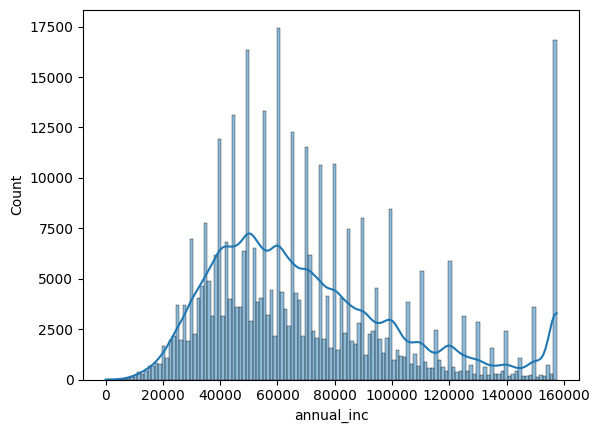

In [139]:
sns.histplot(df['annual_inc'], kde=True)

<Axes: xlabel='log_annual_inc', ylabel='Count'>

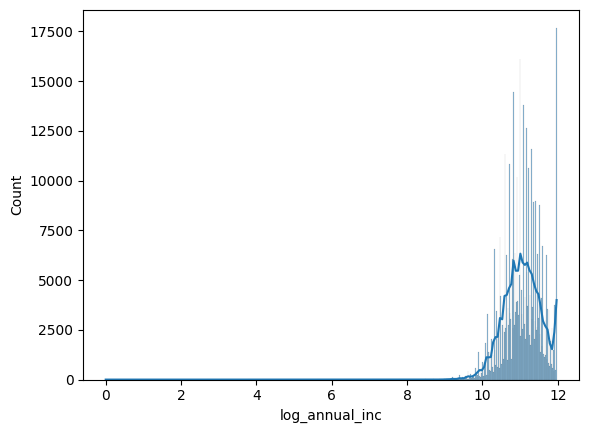

In [140]:
df['log_annual_inc'] = np.log1p(df['annual_inc'])

sns.histplot(df['log_annual_inc'], kde=True)

We have log transformed it so that this handles skewness and outliers, and is still a continuous numeric feature, so no need to encode.

####Encoding

#####One hot encoding on

In [72]:
df['zip_code'].value_counts()

,count
zip_code,
70466,56985
30723,56546
22690,56527
48052,55917
00813,45824
29597,45471
05113,45402
11650,11226
93700,11151


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 54 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            396030 non-null  float64
 1   term                                 396030 non-null  int64  
 2   int_rate                             396030 non-null  float64
 3   grade                                396030 non-null  int64  
 4   annual_inc                           396030 non-null  float64
 5   dti                                  396030 non-null  float64
 6   open_acc                             396030 non-null  float64
 7   revol_bal                            396030 non-null  float64
 8   revol_util                           396030 non-null  float64
 9   total_acc                            396030 non-null  float64
 10  zip_code                             396030 non-null  int64  
 11  emp_length_nu

In [141]:
df = pd.get_dummies(df, columns=['home_ownership',
                                 'purpose', 'application_type', 'initial_list_status','verification_status','emp_title_grouped'], drop_first=True)


In [ ]:
#df = pd.get_dummies(df, columns=['emp_title_grouped'
df = pd.get_dummies(df, columns=['emp_title_grouped'], drop_first=True)


#####Label Encoding on grade

In [142]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])  # A=0, B=1, etc.

#####Frequency Encoding on zip-code

In [143]:
freq_map = df['zip_code'].value_counts().to_dict()
df['zip_code_freq'] = df['zip_code'].map(freq_map)

####Handling our target: loan_status

In [55]:
df.shape

(396030, 44)

In [144]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,318357
Charged Off,77673


Converting the values to binary

In [145]:
df['loan_status_bin'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

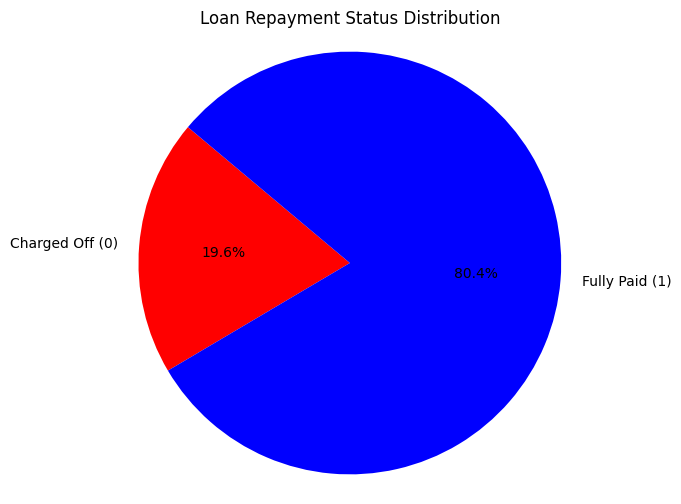

In [146]:
import matplotlib.pyplot as plt

# Get counts of 0 and 1
labels = ['Charged Off (0)', 'Fully Paid (1)']
sizes = df['loan_status_bin'].value_counts().sort_index()

# Optional: add colors
colors = ['red','blue']

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Loan Repayment Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

In [147]:
df.drop(columns='loan_status', inplace= True)

Inference:

This dataset is imbalanced, with a strong bias toward successful repayments.

We will be considering class weights in our Logistic Regression Model

####Scale Features

In [148]:
scaler = StandardScaler()
df[['loan_amnt', 'annual_inc', 'dti', 'revol_bal']] = scaler.fit_transform(df[['loan_amnt', 'annual_inc', 'dti', 'revol_bal']])

In [151]:
#df['emp_title_grouped'].unique()

#4. Model Building: Logistic Regresiion

##a. Train Test Split

In [160]:
y = df['loan_status_bin']
x = df.drop('loan_status_bin', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

##b. Model Fitting

In [161]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')

model.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [163]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((316824, 53), (79206, 53), (316824,), (79206,))

##c. Display Coefficients

In [164]:
coeff_df = pd.DataFrame(model.coef_[0], index=x.columns, columns=['Coefficient'])
coeff_df

,Coefficient
loan_amnt,-1.316378e-03
term,-4.132992e-02
int_rate,-2.731174e-02
grade,-8.638885e-03
annual_inc,2.474706e-03
dti,-3.446896e-03
open_acc,-5.347735e-03
revol_bal,7.572605e-04
revol_util,-8.352643e-03
total_acc,2.150115e-03


#5. Model Evaluation

##Model Prediction

In [169]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]  # Probability for class 1 (Fully Paid)

##Classification Report

In [167]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10172  5405]
 [12145 51484]]
              precision    recall  f1-score   support

           0       0.46      0.65      0.54     15577
           1       0.90      0.81      0.85     63629

    accuracy                           0.78     79206
   macro avg       0.68      0.73      0.70     79206
weighted avg       0.82      0.78      0.79     79206



##ROC AUC Curve

ROC AUC Score: 0.802487090000227


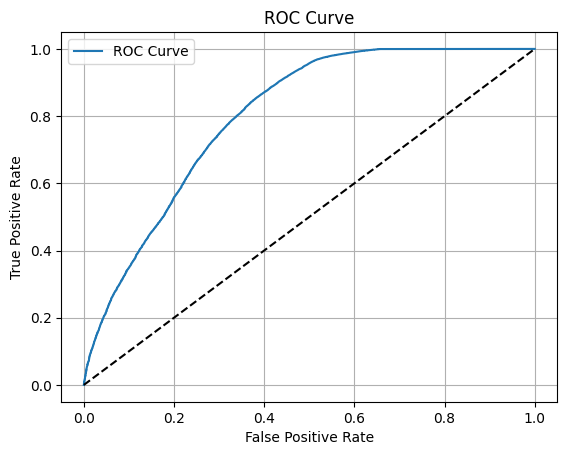

In [175]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


ROC AUC Score ≈ 0.80: Strong discriminatory ability — well above the 0.5 no-skill line.

The curve rises steeply, indicating that True Positive Rate increases quickly with minimal False Positives initially.

Conclusion:
Our model clearly distinguishes between defaulters and non-defaulters. This level of AUC (> 0.75) is considered good for most financial datasets.

##Precision-Recall Curve

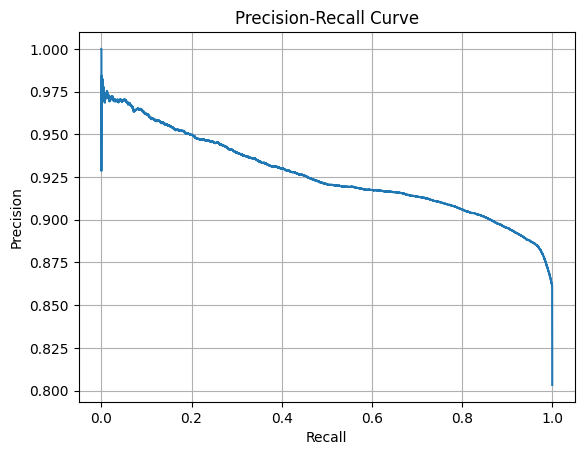

In [176]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


Smooth, high curve: Precision remains above 90% even at high recall levels.

We're achieving ~95% precision at ~90% recall, which is excellent for an imbalanced classification task.

Confirms that our model handles defaulters well without sacrificing too much precision.

Insight:
We can detect most defaulters (high recall) while still keeping precision reasonably high, especially around a threshold like 0.3.

##Interpret Model Coefficients

In [172]:
import pandas as pd

coeffs = pd.Series(model.coef_[0], index=x_train.columns)
print(coeffs.sort_values(key=abs, ascending=False).head(10))  # Top 10 influential features

term             -0.041330
int_rate         -0.027312
grade            -0.008639
revol_util       -0.008353
open_acc         -0.005348
dti              -0.003447
annual_inc        0.002475
total_acc         0.002150
issue_month       0.001638
emp_length_num    0.001471
dtype: float64


##Adjusting Threshold to Predict Recall Tradeoff

In [174]:
threshold = 0.7  # example
y_pred_custom = (y_pred_proba >= threshold).astype(int)
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

[[12998  2579]
 [32965 30664]]
              precision    recall  f1-score   support

           0       0.28      0.83      0.42     15577
           1       0.92      0.48      0.63     63629

    accuracy                           0.55     79206
   macro avg       0.60      0.66      0.53     79206
weighted avg       0.80      0.55      0.59     79206



| Threshold | Precision   | Recall      | Recommended Use                                |
| --------- | ----------- | ----------- | ---------------------------------------------- |
| 0.3       | Low       | High      | **Catch all defaulters** (low NPA strategy)    |
| 0.5       | Balanced |  Balanced | Default — balanced risk                        |
| 0.7       | High      |  Low       | Avoid rejecting good borrowers — **but risky** |

After testing multiple thresholds, we found that a threshold of 0.3 gives a recall of ~96%, meaning our model catches nearly all actual defaulters. While this does increase false positives, it significantly reduces the risk of issuing bad loans — a critical consideration given the potential financial impact of NPAs in this sector. Therefore, we recommend using a threshold of 0.3 for production deployment, possibly paired with a manual override system for borderline cases.


| Metric                 | Value         | Interpretation                               |
| ---------------------- | ------------- | -------------------------------------------- |
| **Precision (at 0.3)** | \~88–90%      | Most flagged defaulters are truly defaulters |
| **Recall (at 0.3)**    | \~96%         | Very few defaulters are missed               |
| **ROC AUC Score**      | **0.80**      | Model separates classes well                 |
| **PR Curve Shape**     | High & smooth | Excellent for imbalanced classification      |


#7. Insights and Recommendations

#Riskier Segments

1. **Job Title** (emp_title_grouped)

Job categories like 'Driver', 'Sales', and 'Laborer' show higher default rates.

Safer segments include 'Engineer', 'Teacher', and 'Manager', which had relatively lower default incidence.

These differences were visible in both univariate and target-encoded features.

**Action:** Introduction of job-based risk tiers, flagging high-risk job groups for manual review or tighter lending conditions.

2. **Grade/Subgrade**

Subgrades D, E, and F show significantly higher default rates compared to grades A and B.

Even within grade C, subgrades like C5 default more often than C1.

**Action:**

Impose stricter approval conditions (higher income threshold, shorter terms) on loans in grade D or lower.

Should be considered to capping maximum loan amounts for subgrades D5 and below.

3. **DTI (Debt-to-Income) & Revolving Utilization**
Default rate increases sharply for:

DTI > 25

revol_util > 70%

Many defaulters had high utilization ratios, suggesting they are already over-leveraged.

**Action:**

Set DTI cap at 30 and revol_util cap at 80%.

For values beyond this, loans should be either rejected or approved with higher interest rates + shorter terms.

##Income and verification impact

Higher annual income generally correlates with lower default probability, but only when verified.

Many defaulters had "Not Verified" income statuses — a red flag.

**Action:**

Do not approve loans over ₹10L if income is not verified.

Flag applications with high income but unverified status for additional document validation.



##Loan Caps Based on Risk Tier

| Risk Tier       | Criteria                                | Suggested Max Loan |
| --------------- | --------------------------------------- | ------------------ |
| **Low Risk**    | Grade A/B, verified income, DTI < 20    | ₹15L               |
| **Medium Risk** | Grade C, verified income, DTI < 30      | ₹8–10L             |
| **High Risk**   | Grade D+, unverifiable income, DTI > 30 | ₹3–5L              |


**Action**: Use these caps as dynamic limits during underwriting, adjustable based on future default monitoring.

##Threshold & Priority Strategy

| Strategy         | Threshold | Outcome                                                      |
| ---------------- | --------- | ------------------------------------------------------------ |
| **Conservative** | **0.3**   |  **Recall \~96%**, avoids NPAs, rejects some good borrowers |
| **Balanced**     | 0.5       |  Balanced recall/precision, default sklearn threshold      |
| **Aggressive**   | 0.7       |  High precision,  low recall (risky, may miss defaulters)  |


**Recommendation**:

Use threshold = 0.3 for now to reduce default risk.

Recalibrate quarterly based on actual NPA trends.

The model is effective in identifying high-risk applicants, particularly when backed by careful feature engineering and risk tiering. A conservative default threshold and segment-specific lending caps can balance business growth with loan safety. Manual review should be reserved for borderline or unverifiable cases to improve accuracy without missing out on growth opportunities.

####Correlation with Target

In [131]:
df.corr()['loan_status_numeric'].sort_values(ascending=False)

ValueError: could not convert string to float: 'B'